In [2]:
%pip uninstall -y numpy
%pip install numpy==1.21.6

Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_vendor\tenacity\__init__.py", line 291, in wrapped_f
    return self(f, *args, **kw)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\natha\anaconda3\Lib\site-packages\pip\_vend

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt
import pyextremes as pyx

In [16]:
def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]
    thresholds = np.linspace(data.quantile(0.2), data.quantile(0.995), 200)
    pyx.plot_mean_residual_life(data, thresholds=thresholds)
    datas = np.sort(data)[::-1]
    k_values = range(4, int(len(datas)/1.3))

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, hill_estimates, 'b-')

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total
    print(F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)) / (1 - xi)
    return VaR, ES

In [36]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Download S&P 500 data
ticker = "^GSPC"
data = yf.download(ticker, start="2008-01-01")['Close']
returns = np.log(data / data.shift(1)).dropna()

# Create volatility proxy (squared returns)
#volatility = returns ** 2

#Create volatility proxy (garch fitted)
from arch import arch_model
garch = arch_model(returns['^GSPC'], vol="GARCH", p=1, q=1)
garch_fit = garch.fit(update_freq=5)
volatility = garch_fit.conditional_volatility


# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vol = scaler.fit_transform(volatility.values.reshape(-1, 1))

# Split data 50:50
split_idx = len(scaled_vol) // 2
train_vol, test_vol = scaled_vol[:split_idx], scaled_vol[split_idx:]
train_returns, test_returns = returns[:split_idx], returns[split_idx:]

[*********************100%***********************]  1 of 1 completed


Optimization terminated successfully    (Exit mode 0)
            Current function value: -14152.91675880728
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


c:\Users\natha\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [37]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20  # Lookback window
X_train, y_train = create_sequences(train_vol, seq_length)
X_test, y_test = create_sequences(test_vol, seq_length)

In [38]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

c:\Users\natha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0043 - mae: 0.0454 - val_loss: 0.0022 - val_mae: 0.0258
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - mae: 0.0293 - val_loss: 0.0017 - val_mae: 0.0216
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0215
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - mae: 0.0243 - val_loss: 0.0014 - val_mae: 0.0207
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - mae: 0.0253 - val_loss: 0.0013 - val_mae: 0.0194
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - mae: 0.0239 - val_loss: 0.0012 - val_mae: 0.0184
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - mae: 0.0221 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - mae: 0.0222 - val_loss: 0.0010 - val_mae: 0.0174
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              MLE model              
-------------------------------------
free parameters: c=0.238, scale=0.613
fixed parameters: floc=1.466         
AIC: 216.948                         
loglikelihood: -106.431              
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.23836998317924019, 'scale': 0.6133037467808302}
0.06899724011039558
2.969971741070868
[[-0.01993083]
 [-0.01910853]
 [-0.01900465]
 ...
 [-0.02214812]
 [-0.02323241]
 [-0.02218051]]
Ticker         ^GSPC
Date                
2016-09-20  0.000299
2016-09-21  0.010858
2016-09-22  0.006479
2016-09-23 -0.005753
2016-09-26 -0.008625
...              ...
2025-06-05 -0.005291
2025-06-06  0.010228
2025-06-09  0.000920
2025-06-10  0.005468
2025-06-11 -0.002748

[2194 rows x 1 columns]


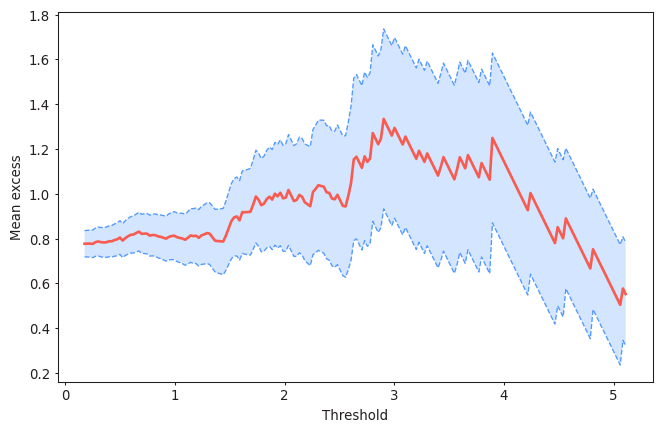

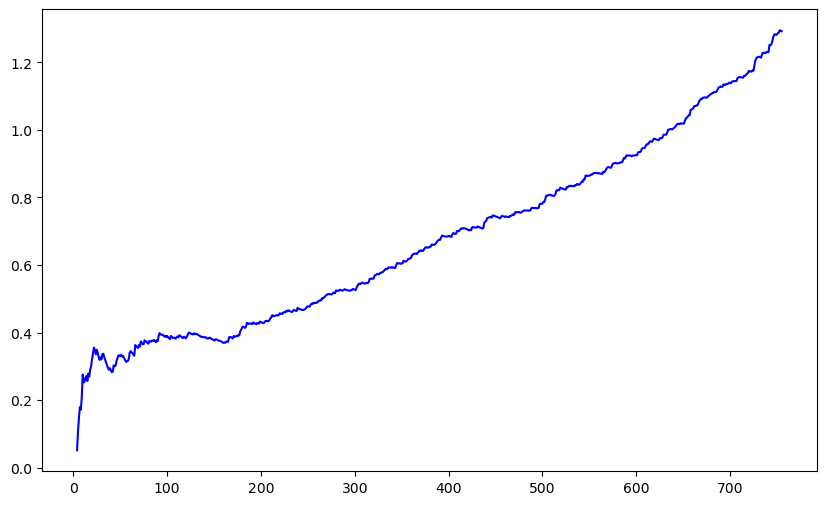

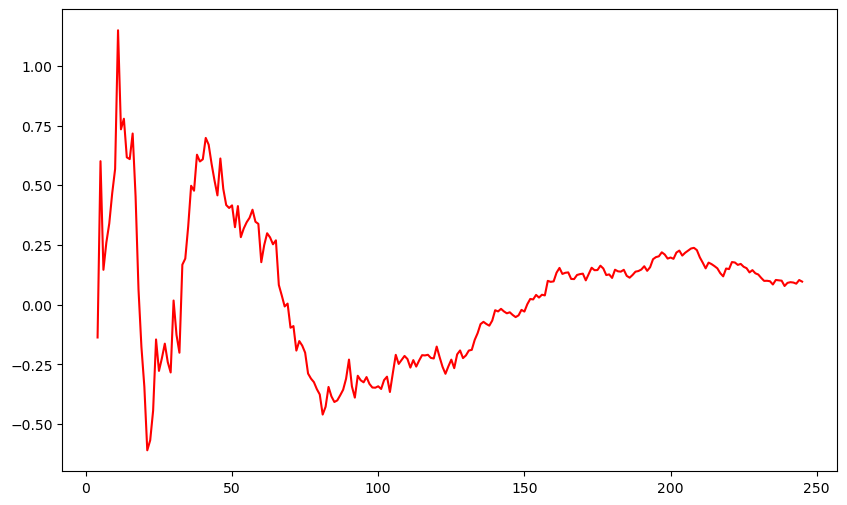

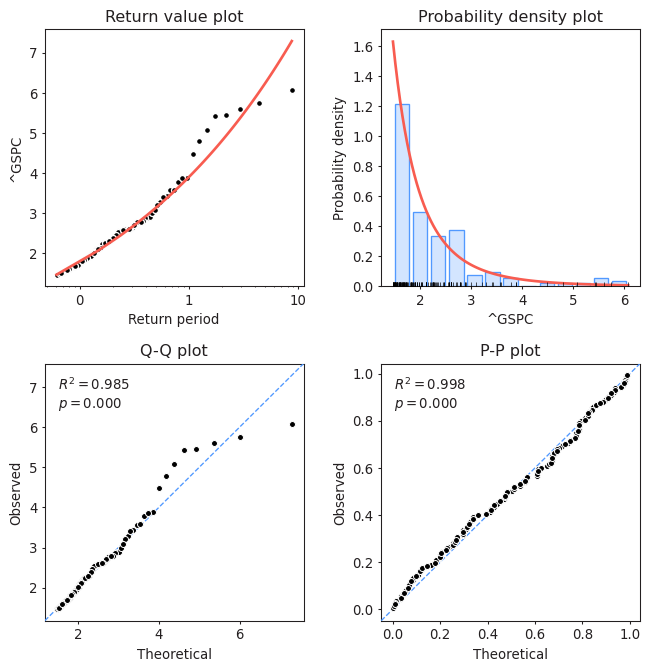

In [39]:
volatility_forecasts = model.predict(X_test)
volatility_forecasts = scaler.inverse_transform(volatility_forecasts)

residuals = test_returns[20:] / volatility_forecasts
#print(residuals)

residuals=residuals['^GSPC']

sorted_ml_sp500 = threshold_picking(residuals)
VaR_quantile = sorted_ml_sp500[150]
params = modeling(residuals, VaR_quantile)
VaR_ml, ES_ml = prediction(params, residuals, VaR_quantile, level=0.01)

print(VaR_ml)

VaR_forecast = volatility_forecasts * -VaR_ml
print(VaR_forecast)
print(test_returns)

# Align returns with predictions (assuming seq_length was used in training)
#returns_aligned = test_returns[seq_length:]

In [40]:
from scipy.stats import chi2

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test
    actual_returns = np.asarray(actual_returns).flatten()
    var_forecast = np.asarray(var_forecast).flatten()
    
    min_length = min(len(actual_returns), len(var_forecast))
    actual_returns = actual_returns[:min_length]
    var_forecast = var_forecast[:min_length]

    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

conditional_coverage_test(test_returns, VaR_forecast, alpha=0.01)

{'LR_UC': 0.0031285633807556223,
 'p-value_UC': 0.9553947338993578,
 'Reject_UC?': False,
 'LR_IND': 1.505464924915205,
 'p-value_IND': 0.21983240489018685,
 'Reject_IND?': False,
 'LR_CC': 1.5085934882959606,
 'p-value_CC': 0.4703412686994005,
 'Reject_CC?': False,
 'Violation Rate': 0.010119595216191352,
 'Expected Rate': 0.01,
 'Transition Matrix': [[2130, 21], [21, 1]]}